# Interactive plotting with plotly

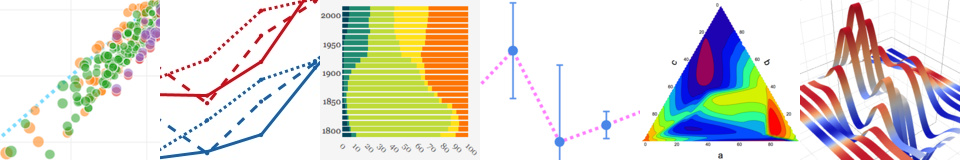

### In this notebook:
<ul>
<li><a href='#simple_map'>A simple map</a></li>
<li><a href='#first_plot'>Your first real plot</a></li>
<li><a href='#heatmaps'>Heatmaps</a></li>
<li><a href='#aggregation'>Aggregation</a></li>
<li><a href='#pie'>Pie charts</a></li>
<li><a href='#bar'>Bar charts</a></li>
</ul>

Now we'll introduce one of Python's popular plotting libraries: plotly.

Check out some of the cool things you can do with plotly [here](https://plot.ly/python/) - including animated plots!

Plotly's strength is in easily creating interactive plots to view in a web browser. But it's not just a library: [plot.ly](https://plot.ly) is also a website where you can find and share plots!

By default plotly runs online, meaning it saves your plot to your online plotly account. However for simplicity we'll be using it in offline mode, i.e. just in this notebook.

First we'll catch up to where we left off in the previous notebook: filter our WFS query to Sydney 2017 and read it to a dataframe called `listings` .

In [ ]:
import pandas
wfs_query = 'https://citydata.be.unsw.edu.au/geoserver/wfs?srsName=EPSG%3A4326&typename=geonode%3AInsideAirbnb_44_2015_17&outputFormat=csv&version=1.0.0&service=WFS&request=GetFeature'
maxFeatures_param = '&maxFeatures=10'
PropertyName_param = '&PropertyName=City,ScrapeDate,PropertyID,HostID,Latitude,Longitude,Price,ListType,MinNights'
cql_filter_param = "&cql_filter=City='Sydney'+AND+ScrapeDate='2017-04-03T00:00:00'"

url = wfs_query + PropertyName_param + cql_filter_param #  + maxFeatures_param
listings = pandas.read_csv(url)

listings.head()


Before we can use plotly  we need to import it.

To save typing later though, we'll import just the bits we need and assign a short alias to `graph_objs`. But why these bits?


Plotly graphs are [JSON](https://en.wikipedia.org/wiki/JSON) objects with *dictionary* structures.

You can create Plotly graphs manually by creating a dictionary form scratch, but programmers want efficiency!

That's the reason why we are going to import `Graph_objs`. It contains functions which will help us generate graph objects (or 'figures') to visualise data much more easily.

As mentioned above, Plotly is more than a library. You can upload your images onto the websites, but for this course, we will be focusing on generating figures offline in our Jupyter notebooks. 

*init_notebook_mode()* tells plotly that we want to plot graphs inside this Jupyter Notebook (instead of opening a new webpage), and when calling the `iplot()` function, the figure (JSON source file) will be injected into the notebook and you can view it right here.

Let's see how it works.

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode() # Plot data in the notebook not to a file

<a id='simple_map'></a>
## A simple map

For our first plot let's just use latitude by longitude as a scatter plot to produce a simple map.

**To generate a plot we need the following objects:**  
* `trace` - a data series and the specifications for how to plot it
* `layout` - the look of the plot and other features unrelated to the data
* `figure` - the final object to be plotted, containing one or more traces and the layout

After a `figure` object is created, don't forget to call `iplot()` function to plot it.

In [ ]:
# Use plotly's Scatter function to define the trace
trace = go.Scatter(
                    x=listings['Longitude'], y=listings['Latitude'], # Which parts of the data to use
                    mode='markers',   # Markers not lines
                    marker=dict(      # Size and colour of markers
                            size='5',
                            color = 'rgb(150,80,200)' # Marker colour in RGB (Red, Green, Blue) format
                            ),
                    name='map'        # Additional options
                   )

# Define the layout
layout = go.Layout(title='Simple Map of Sydney Airbnb Listings 2017',
                   plot_bgcolor='rgb(230,230,230)', # Background colour in RGB (Red, Green, Blue) format
                   xaxis = dict(title='Longitude'),  # Axis titles
                   yaxis = dict(title='Latitude')
                  )

# Combine the trace and the layout into a figure
fig = go.Figure(data=[trace], layout=layout)

# Plot it!
iplot(fig)

If you hover your plot you'll see a toolbar in the top-right corner. This contains interactive widgets to help you explore the data.

You can *save or upload the figure* (to the plotly website!), or explore it by _zooming in/out_, _panning around_, and also _selecting by box/lasso_.

Feel free to play around with those tools! If you can't find your plots, try  _reset_ or _autoscaled_. 

If you don't understand what the last three tools are for, don't worry! We will explain them later.

Where are most of the Airbnb listings?

Generally, houses are more expensive nearer to the coast.

<a id='first_plot'></a>
## Your first real plot

Does the same apply to Airbnb? Let's plot price against longitude to find out.

**Copy the code above into the cell below, and change it to plot Price instead of Latitude. Change the title too.**

Where are the more expensive Airbnb listings in your plot above?

<a id='heatmaps'></a>
## Heatmaps
Let's make a heatmap to show price using coloured markers on the map.

What part of our map code would we need to change?

We'll need to change the marker colour in the trace object from a fixed colour to one based on price. We'll also clip the upper outliers - listings above $1000 per night - to better show the variance of most of the data. (Try experimenting with different values here.)

Finally we'll show a legend for the heatmap.

In [ ]:
trace = go.Scatter(
                    x=listings['Longitude'], y=listings['Latitude'], # Data
                    mode='markers', name='map',
                    marker=dict(
                                size='5',
                                color = listings['Price'].clip_upper(1000), 
                                #clip the price to be max 1000 to better show the variance of price
                                colorscale='Viridis',
                                showscale=True
                                )
                    )
layout = go.Layout(title='Heatmap of Sydney Airbnb Listings by Price, 2017',
                   plot_bgcolor='rgb(230, 230,230)',
                   xaxis = dict(title='Longitude'),
                   yaxis = dict(title='Latitude')
                  )

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

<a id='aggregation'></a>
## Aggregation

Let's look at the Airbnb hosts. How many listings does each host manage? We need to aggregate the data by HostID and plot the number of listings for each host. To do this we must construct the data 'manually' rather than using the Scatter function which does not support transforms.

In [ ]:
trace = [{
  'type': 'scatter',
  'x': listings['HostID'],
  'y': listings['PropertyID'],
  'mode': 'markers',
  'transforms': [{
    'type': 'aggregate',
    'groups': listings['HostID'],
    'aggregations': [{'target': 'y', 'func': 'count', 'enabled': True}]
  }]
}]

layout = go.Layout(title='Sydney Airbnb Listings Per Host 2017',
                   plot_bgcolor='rgb(230, 230,230)')

iplot({'data': trace, 'layout': layout}, validate=False)

Some Airbnb hosts manage over a hundred properties!

How much are these portfolios worth? Let's look at potential nightly income, i.e. the sum of the nightly rates for all properties hosted by each host.

In [ ]:
host_by_total_price = [dict(
  type = 'scatter',
  x = listings['HostID'],
  y = listings['Price'],
  mode = 'markers',
  transforms = [dict(
    type = 'aggregate',
    groups = listings['HostID'],
    aggregations = [dict(
        target = 'y', func = 'sum', enabled = True),
    ]
  )]
)]

iplot({'data': host_by_total_price}, validate=False)


Wow some of those portfolios are huge!

<a id='pie'></a>
## Pie charts
Now let's try some new charts!

There are three types of listings available on Airbnb: _Entire home/apartment, private room and shared room_. 

Which category has the most listings? Let's find out by using a pie chart!


In [ ]:
labels = listings['ListType'].value_counts().index
values = listings['ListType'].value_counts()
colors = ['#FEBFB3', '#E1396C', '#96D38C']#, '#D0F9B1']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value', #Change the text and hover info
               hole=0.4, # Make a donut style pie chart!
               textfont=dict(size=20),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))
layout = go.Layout(title='Sydney Airbnb Listings 2017 - List type',
                   plot_bgcolor='rgb(230, 230,230)')

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

Looks like "Entire home/apt" is dominating the Sydney market!

<a id='bar'></a>
## Bar charts
So in terms of minimum booking nights required, is there a difference between those three categories?

Let's try a bar chart with 3 groups to see if we can find the answer!



In [ ]:
# Remove the longer minimum stays which have only a small number of records
listings_shortstay = listings[listings['MinNights'] <= 7]

Entire_home_records = listings_shortstay[listings_shortstay['ListType'] == 'Entire home/apt']['MinNights']
Private_room_records = listings_shortstay[listings_shortstay['ListType'] == 'Private room']['MinNights']
Shared_room_records = listings_shortstay[listings_shortstay['ListType'] == 'Shared room']['MinNights']

trace1 = go.Bar(
    x=Entire_home_records.value_counts().index,  # The pandas series method value_counts() returns counts of unique values
    y=Entire_home_records.value_counts() / len(Entire_home_records) * 100,
    name='Entire home/apartment'
)

trace2 = go.Bar(
    x=Private_room_records.value_counts().index,
    y=Private_room_records.value_counts() / len(Private_room_records) * 100,
    name='Private room'
)

trace3 = go.Bar(
    x=Shared_room_records.value_counts().index,
    y=Shared_room_records.value_counts() / len(Shared_room_records) * 100,
    name='Shared room'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title ='Sydney Airbnb Listings 2017 - Minimum Booking Nights required',
    barmode ='group', # Show bars side by side
    xaxis = dict(title='Minimum Nights'),
    yaxis = dict(title='Percentage')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Looks like you will have more choice of entire home/apartments if you are staying for more than 1 night!

Remember those interactive tools we didn't used before? Let's try the last two - Show closest data/compare data on hover.

Click on each tool and move your cursor to a group of bars. Do you notice the difference?

* *Compare data on hover* gives you information on all plots with the same X value
* *Show closest data on hover* provides you only the closest data points to your cursor

Now you know how to plot some basic charts with Plotly! Here is a quick [cheatsheet](https://images.plot.ly/plotly-documentation/images/python_cheat_sheet.pdf) for your reference if you want to take a peak of other kind of charts.